Opening file and making a dataframe out of it

In [1]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats

# Step 1: Read the CSV file into a DataFrame
file_path = 'Stocks/evtc.us.txt'  # Replace with your actual file path
df = pd.read_csv(file_path)
numeric_columns = ["Open", "High", "Low", "Close", "Volume"]

# Step 2: Convert the 'Date' column to datetime format (assuming the file has a Date column)
df['Date'] = pd.to_datetime(df['Date'])

# Generate the full date range (weekends included)
full_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())

# Create a new DataFrame with the full date range
full_df = pd.DataFrame(full_dates, columns=['Date'])

# Merge the original data with the full date range, filling missing dates with NaN
df = pd.merge(full_df, df, on='Date', how='left')

all_columns = numeric_columns.copy()
all_columns.append("Date")

df = df[all_columns]

Filling missing values

In [2]:
df["Volume"].fillna(0, inplace=True)
df["Open"].interpolate(inplace=True)
df["High"].interpolate(inplace=True)
df["Low"].interpolate(inplace=True)
df["Close"].interpolate(inplace=True)

C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\3032190843.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Volume"].fillna(0, inplace=True)
C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\3032190843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

Moving average

In [10]:
df_average = df.copy(deep=True)
df_average[numeric_columns] = df_average[numeric_columns].rolling(window=5).mean()
df_average.bfill(inplace=True)
print(df_average)

        Open     High      Low    Close     Volume       Date
0     19.069  19.2332  18.2892  18.4926  4994499.8 2013-04-12
1     19.069  19.2332  18.2892  18.4926  4994499.8 2013-04-13
2     19.069  19.2332  18.2892  18.4926  4994499.8 2013-04-14
3     19.069  19.2332  18.2892  18.4926  4994499.8 2013-04-15
4     19.069  19.2332  18.2892  18.4926  4994499.8 2013-04-16
...      ...      ...      ...      ...        ...        ...
1669  14.650  14.8300  14.3500  14.6200   407899.8 2017-11-06
1670  14.610  14.8100  14.2900  14.5200   518495.0 2017-11-07
1671  14.490  14.7000  14.1000  14.4000   779979.4 2017-11-08
1672  14.390  14.5450  13.8700  14.1300  1118417.0 2017-11-09
1673  14.100  14.2750  13.6400  13.8900  1225190.8 2017-11-10

[1674 rows x 6 columns]


Find and remove outliers (new)

C:\Users\Tim\AppData\Local\Temp\ipykernel_24716\94265111.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cleaned[o][i] = float('nan')
C:\Users\Tim\AppData\Local\Temp\ipykernel_24716\94265111.py:17: SettingWithCopyWarning: 
A value is

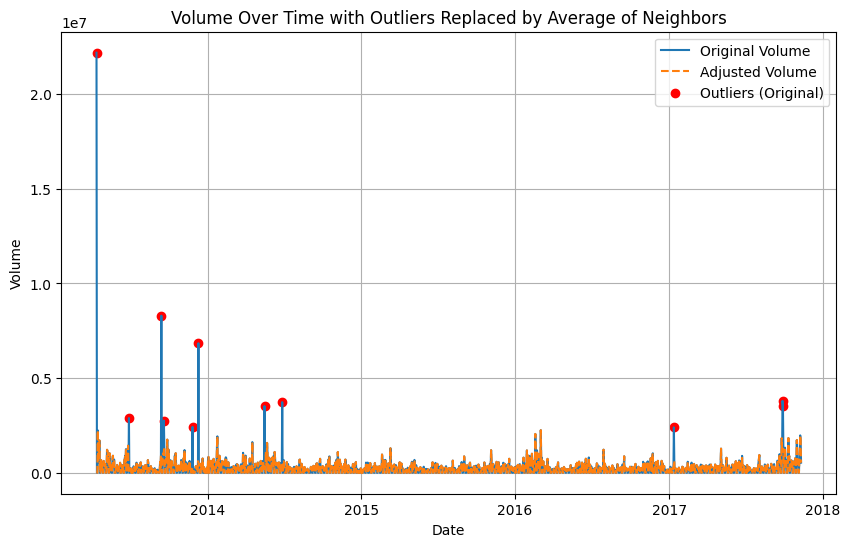

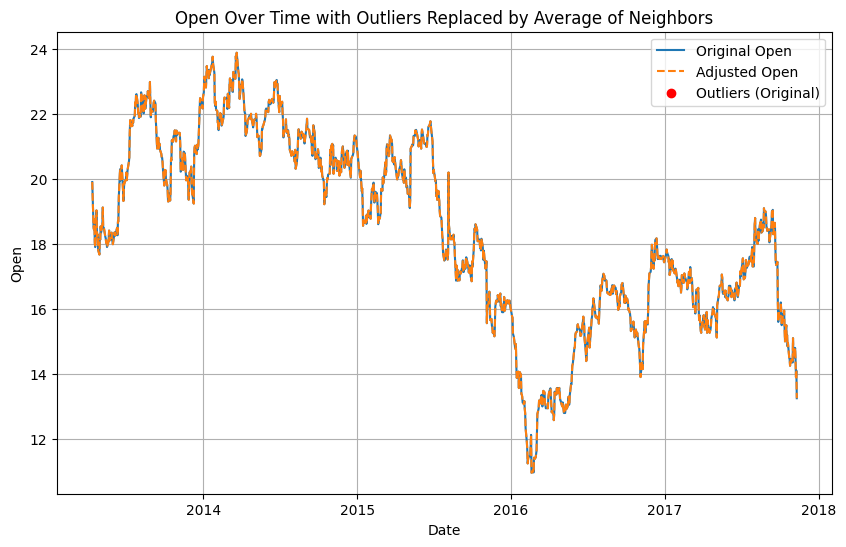

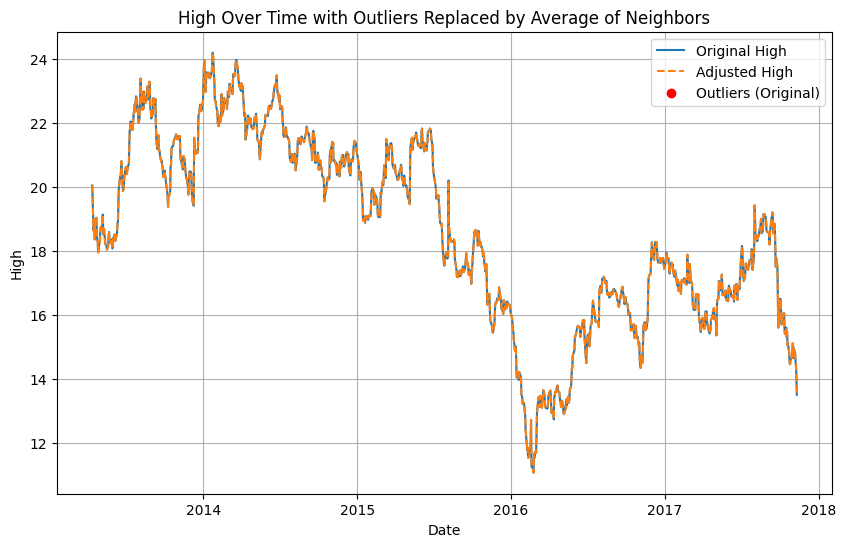

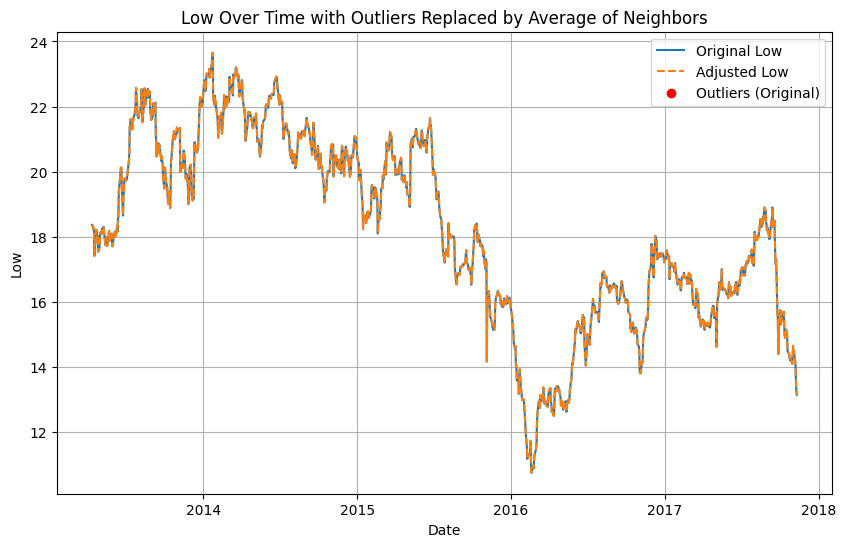

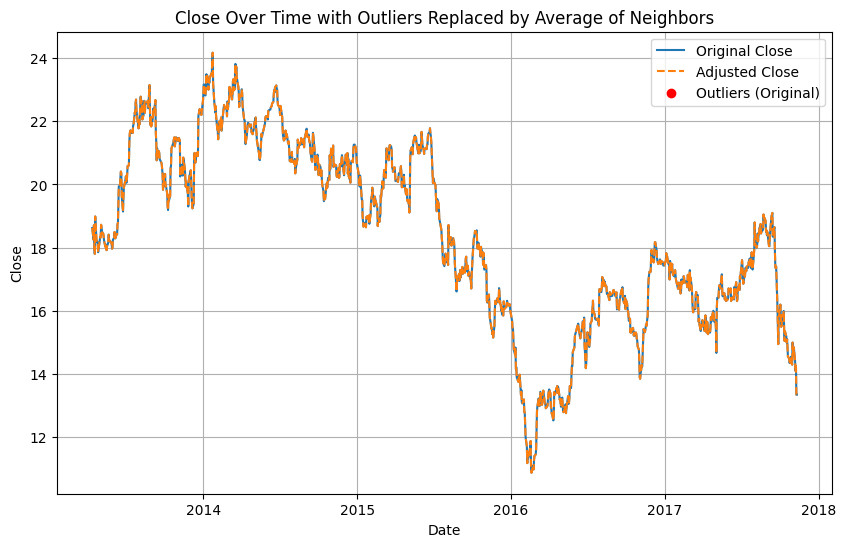

In [4]:
z_scores = {}

for column_name in numeric_columns:
    z_scores[column_name] = np.abs(stats.zscore(df[column_name]))

z_score_threshold = 3

outliers = {}
for column_name in z_scores.keys():
    outliers[column_name] = (z_scores[column_name] > z_score_threshold)

df_cleaned = df.copy(deep=True)

for o in outliers.keys():
    for i, x in enumerate(outliers[o]):
        if x:
            df_cleaned[o][i] = float('nan')

for column_name in numeric_columns:
    df_cleaned[column_name].interpolate(inplace=True)
    df_cleaned[column_name].bfill(inplace=True)

# TODO: Plot outliers over the other values


def plot_original_and_adjusted(df_before, df_after, column_name):
    """
    Function to plot the original and adjusted data, highlighting the outliers.
    
    Parameters:
    - df: The input dataframe containing the original and adjusted data.
    - column_name: The name of the column to plot.
    
    Returns:
    - A plot showing the original and adjusted column values over time, with outliers marked.
    """

    # Plot the original and adjusted column data
    plt.figure(figsize=(10, 6))
    plt.plot(df_before['Date'], df_before[column_name], label=f'Original {column_name}')
    plt.plot(df_after['Date'], df_after[column_name], label=f'Adjusted {column_name}', linestyle='--')

    # Highlight the outliers in the original data
    outliers = df_before[~df_before[column_name].isin(df_after[column_name])]
    plt.scatter(outliers['Date'], outliers[column_name], color='red', label='Outliers (Original)', marker='o')

    # Customize the plot
    plt.title(f'{column_name} Over Time with Outliers Replaced by Average of Neighbors')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

plot_original_and_adjusted(df, df_cleaned, "Volume")
plot_original_and_adjusted(df, df_cleaned, "Open")
plot_original_and_adjusted(df, df_cleaned, "High")
plot_original_and_adjusted(df, df_cleaned, "Low")
plot_original_and_adjusted(df, df_cleaned, "Close")


Time series decomposition

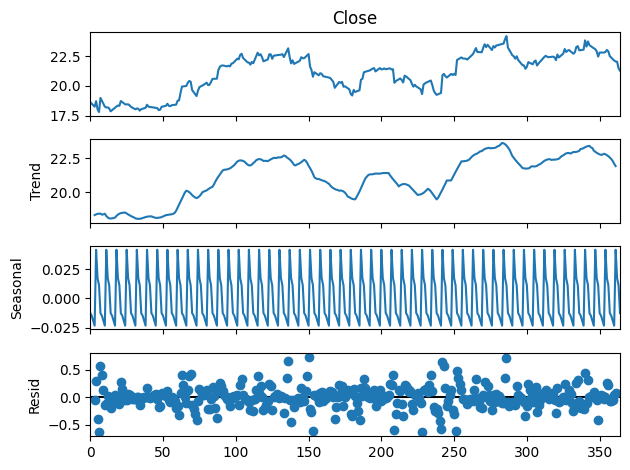

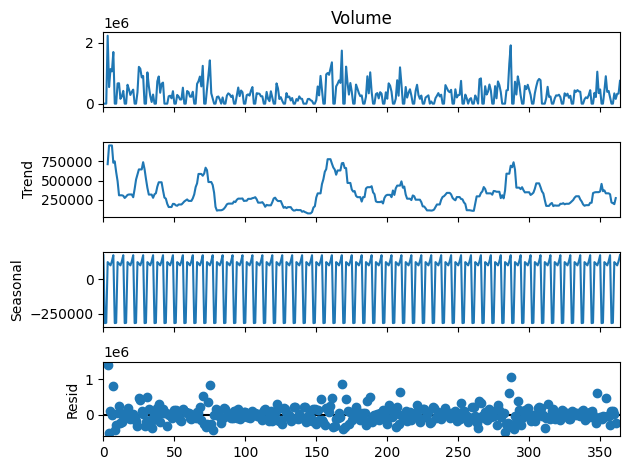

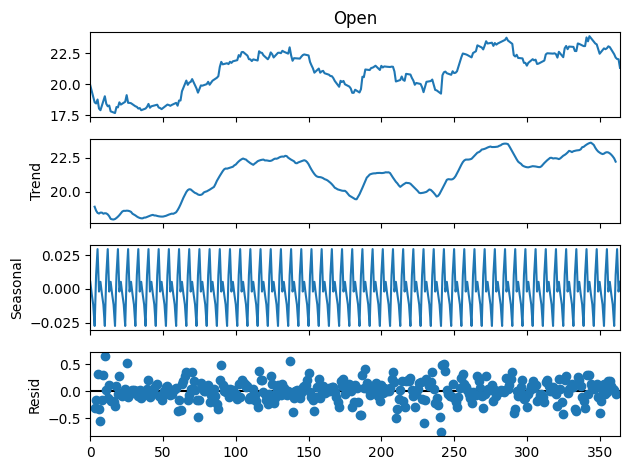

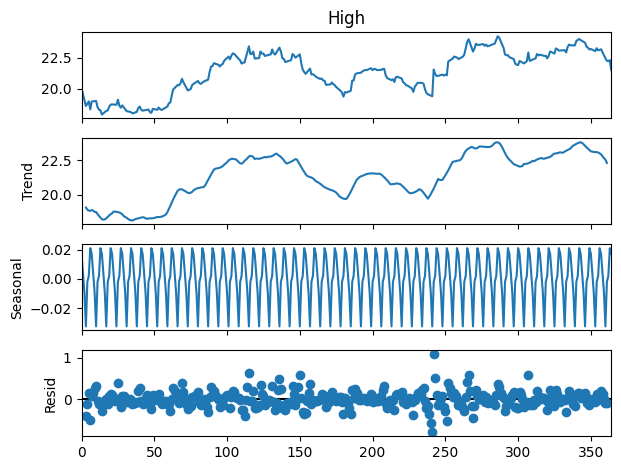

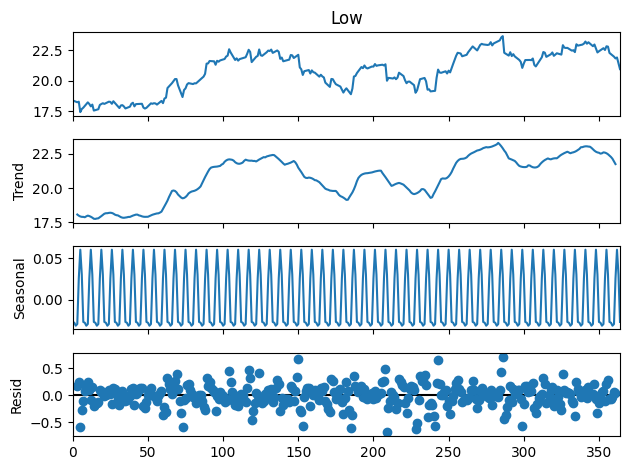

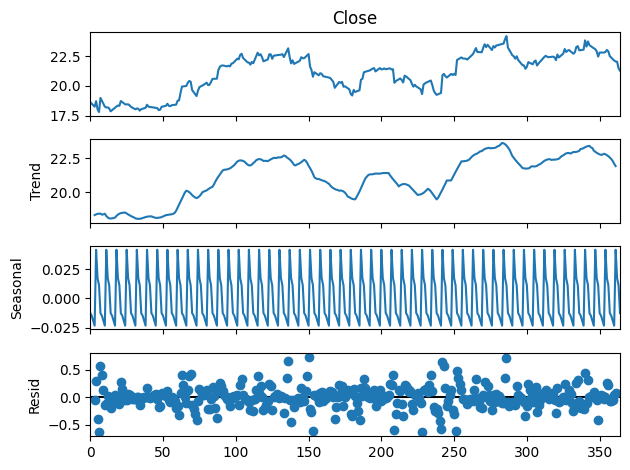

In [5]:
# dfc.dropna(inplace=True)
dfc_year = df_cleaned.head(365)
# print(dfc_year)

def do_seasonal_additive_decompose(dfc, column_name, period=7):
    return seasonal_decompose(dfc[column_name], model="additive", period=period)

volume_result = do_seasonal_additive_decompose(dfc_year, "Volume")
volume_result.plot()
open_result = do_seasonal_additive_decompose(dfc_year, "Open")
open_result.plot()
high_result = do_seasonal_additive_decompose(dfc_year, "High")
high_result.plot()
low_result = do_seasonal_additive_decompose(dfc_year, "Low")
low_result.plot()
close_result = do_seasonal_additive_decompose(dfc_year, "Close")
close_result.plot()


Scale the data

In [9]:
def get_scaled_data_with_date_as_days_since_unix_epoch(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_columns])
    df_new = pd.DataFrame(scaled_data, columns=numeric_columns)
    unix_epoch = pd.Timestamp('1970-01-01')
    df_new['Days_since_unix_epoch'] = (df['Date'] - unix_epoch).dt.days
    return df_new

df_scaled = get_scaled_data_with_date_as_days_since_unix_epoch(df_cleaned)
print(df_scaled)

          Open      High       Low     Close    Volume  Days_since_unix_epoch
0     0.510461  0.484772  0.055489  0.069200 -0.904118                  15807
1     0.353101  0.323117  0.038653  0.026433 -0.904118                  15808
2     0.195742  0.161462  0.021817 -0.016334 -0.904118                  15809
3     0.038382 -0.000194  0.004981 -0.059101  6.780314                  15810
4     0.006587  0.062316  0.021004  0.100930  0.971727                  15811
...        ...       ...       ...       ...       ...                    ...
1669 -1.254481 -1.316334 -1.395998 -1.387283  1.571215                  17476
1670 -1.375438 -1.402199 -1.448248 -1.490751  3.241059                  17477
1671 -1.565515 -1.453718 -1.622412 -1.439017  5.867017                  17478
1672 -1.496396 -1.548170 -1.726911 -1.749421  4.906595                  17479
1673 -1.790150 -1.762832 -1.761744 -1.749421  0.929106                  17480

[1674 rows x 6 columns]


Train split

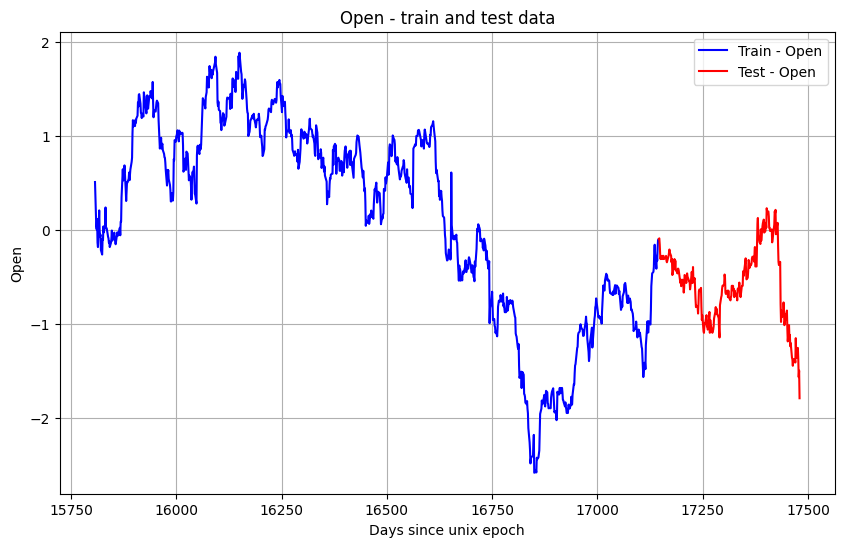

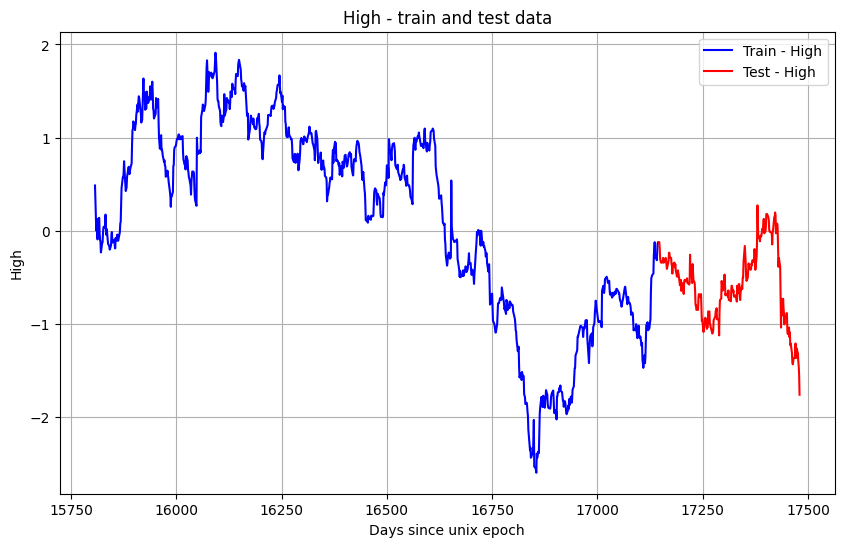

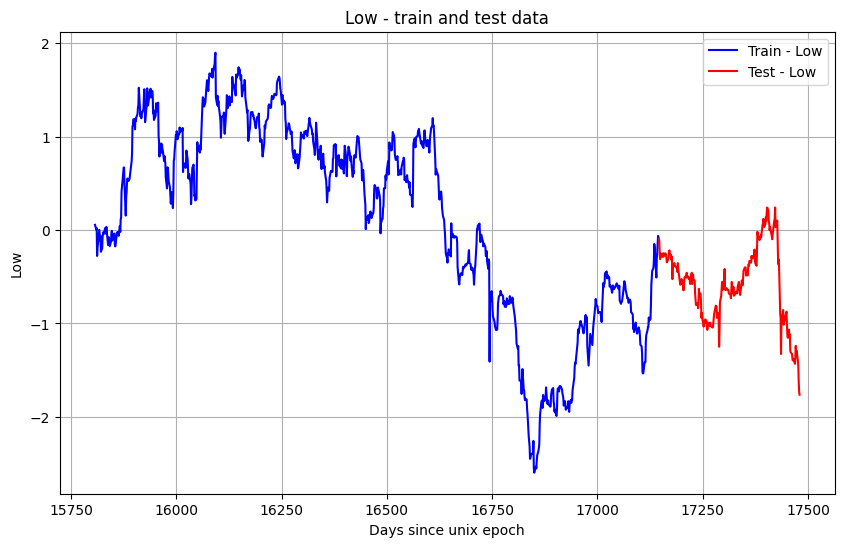

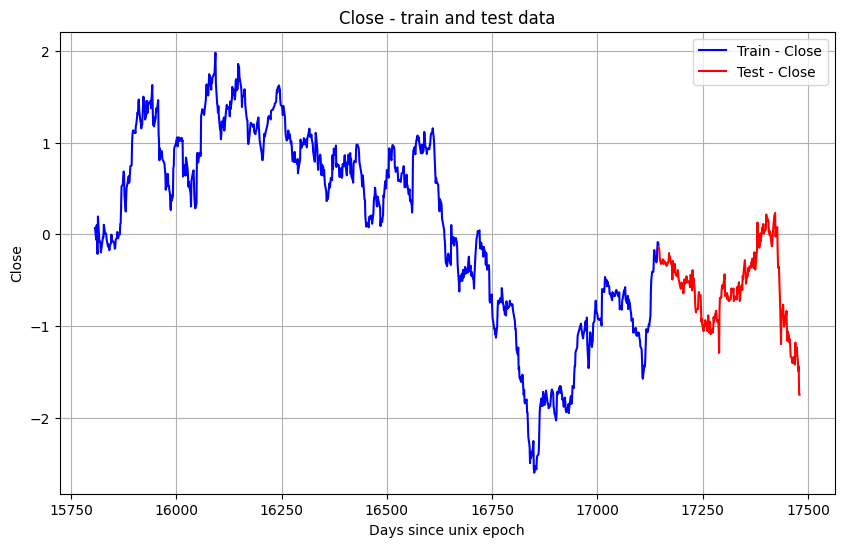

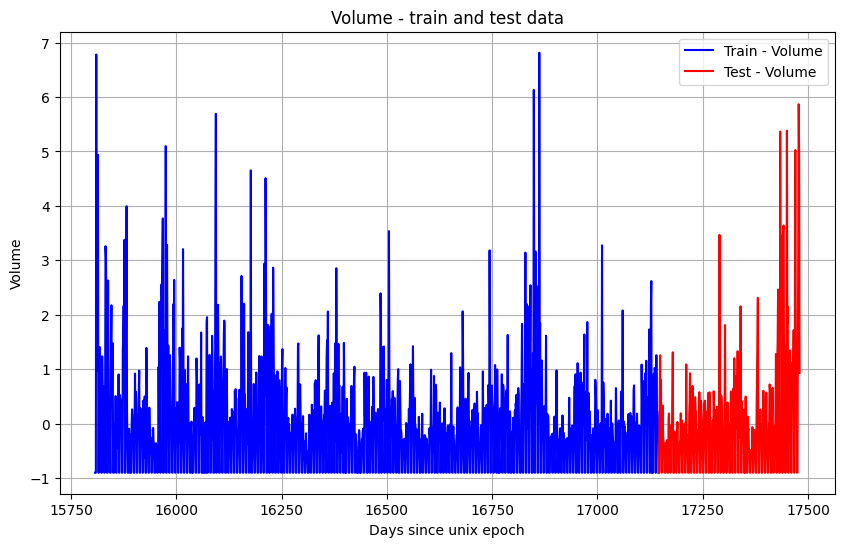

In [10]:
train_scaled, test_scaled = train_test_split(df_scaled, test_size=0.2, shuffle=False)

def plot_train_and_test(train, test, column_name):
    # Plot the original and adjusted column data
    plt.figure(figsize=(10, 6))
    plt.plot(train['Days_since_unix_epoch'], train[column_name], label=f'Train - {column_name}', color="blue")
    plt.plot(test['Days_since_unix_epoch'], test[column_name], label=f'Test - {column_name}', color="red")

    # Customize the plot
    plt.title(f'{column_name} - train and test data')
    plt.xlabel('Days since unix epoch')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

for name in numeric_columns:
    plot_train_and_test(train_scaled, test_scaled, name)

PCA

          PC1       PC2
0   -0.516932 -0.896105
1   -0.536917 -0.314596
2   -0.719913  0.480731
3   -0.872941  1.262488
4   -0.884715  0.124142
..        ...       ...
330 -2.965591  1.579044
331 -3.147453  3.248339
332 -3.330376  5.875670
333 -3.550093  4.914664
334 -3.820452  0.936229

[335 rows x 2 columns]


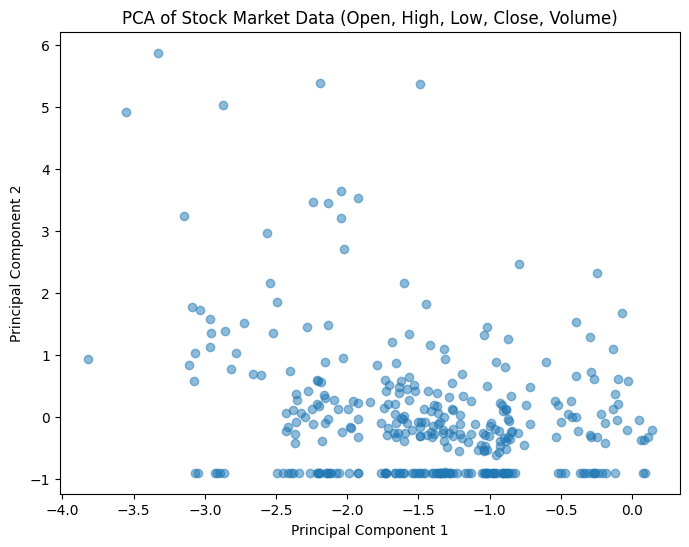

In [12]:
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled[numeric_columns])
test_pca = pca.transform(test_scaled[numeric_columns])
# print(train_pca)
# print(test_pca)
test_p_df = pd.DataFrame(data=test_pca, columns=["PC1", "PC2"])

print(test_p_df)

# Example 1D data
# Create the figure and axis
# plt.figure(figsize=(8, 2))  # Make the plot wider and less tall for a horizontal feel
# # Plot the horizontal line (constant value for y)
# plt.plot(test_p_df, np.zeros(len(test_p_df)), linestyle='-', color='green', linewidth=2)
# # Add square markers on the line
# plt.scatter(test_p_df, np.zeros(len(test_p_df)), color='green', edgecolor='black', marker='s', s=200)
# # Customize the plot
# plt.yticks([])  # Remove the y-axis
# plt.ylim(-0.5, 0.5)  # Keep a small y-range to maintain the horizontal line
# plt.title('Custom Horizontal Line with Square Markers')
# # Show the plot
# plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(test_p_df['PC1'], test_p_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Stock Market Data (Open, High, Low, Close, Volume)')
plt.show()

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(test_p_df['PC1'], test_p_df['PC2'], test_p_df['PC3'], alpha=0.5)
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.set_title('3D PCA of Stock Market Data')
# plt.show()